In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from keras import optimizers
from glob import glob
import gdal
import os
import yaml 
from PIL import Image
%matplotlib inline

import strider

import sys
sys.path.insert(0,'/contents/src')
import segnet_model
import segtools

Using TensorFlow backend.


In [2]:
model_dirc = '/contents/fit_models/v4'
model_json = '%s/seg_net.json'%(model_dirc)
model_weight = '%s/seg_net.h5'%(model_dirc) 
segnet_model = segnet_model.import_model(model_json, model_weight)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
segnet_model.compile(loss='categorical_crossentropy', \
                     optimizer=opt, metrics=['categorical_accuracy'])
print('Model compiled!')

Model compiled!


In [3]:
with open('parameters.yaml') as p_yaml:
    params = yaml.safe_load(p_yaml)
params['window_bands'] = np.array(params['window_bands'])

In [6]:
tifs = sorted(glob('*.tif'))
num_classes = 2
input_shape = 256
for i in range(len(tifs)):
    s_image = strider.Image(tifs[i]) #instantiate strider Image object
    # acquire data
    data_dirc = '/contents/bin/'
    predict_x = segtools.get_data('%s'%(data_dirc))
    out_files = sorted(glob('%s/*.png'%(data_dirc)))
    predict_x_batch = segtools.pre_process_x(predict_x)
    # predict on data
    pr = segnet_model.predict(predict_x_batch, verbose=1)
    for j in range(len(pr)):
        prediction = pr[j].reshape((input_shape,input_shape,num_classes))
        out = (prediction[:,:,0].reshape((input_shape,input_shape))*255).astype('uint8')
        outname = '%s/%s'%('/contents/bin/', os.path.basename(out_files[j]))
        Image.fromarray(out).save(outname)
    s_image.collect_proc_windows()
    mosaic = s_image.reassemble_windows()
    s_image.remove_window_files() #clean up
    out_tiffile='%s/%s'%('/contents/bin/out',s_image.filename)
    ref_tif = gdal.Open(s_image.filename)
    ref_img = ref_tif.ReadAsArray()
    border_mask = np.zeros((np.shape(ref_img)[1], np.shape(ref_img)[2])).astype('bool')
    border_mask[(ref_img[0,:,:]==0) & (ref_img[1,:,:]==0) & \
                (ref_img[2,:,:]==0)] = True
    bufr = 64 #cell buffer
    border_mask = segtools.extend_border_mask(border_mask, bufr)
   
    out_img = mosaic[:,:,0]
    out_img[border_mask] = 0
    alpha_mask = 255-out_img
    segtools.export_tif(out_img, ref_tif, out_tiffile, alpha_mask)

1435/1435 [==============================] - 16s 11ms/step


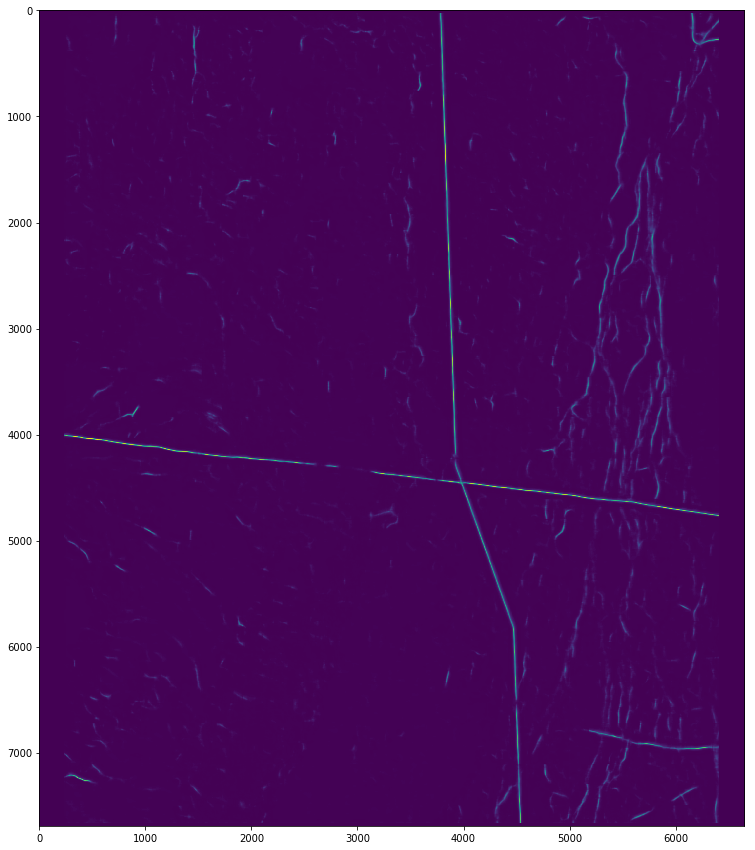

In [5]:
f,ax =plt.subplots(1,1,figsize=(15,15))
ax.imshow(mosaic[:,:,0])
#ax.imshow(border_mask, alpha=0.1)

    

In [12]:
print(tifs[8])

m_3711403_nw_11_1_20150725.tif


In [44]:
np.where(border_mask)


(array([   0,    0,    0, ..., 7689, 7690, 7690]),
 array([   2,    3,    4, ..., 6437,  167, 6437]))

In [6]:
print(np.shape(mosaic))
print(np.shape(ref_img))


(7691, 6610, 1)
(4, 7691, 6610)


# Inspect outputs...

In [11]:
tif_file = sorted(glob('*.tif'))
tif_img = gdal.Open(tif_file[0])
tif_img = np.moveaxis(tif_img.ReadAsArray()[:3,:,:],0,-1)

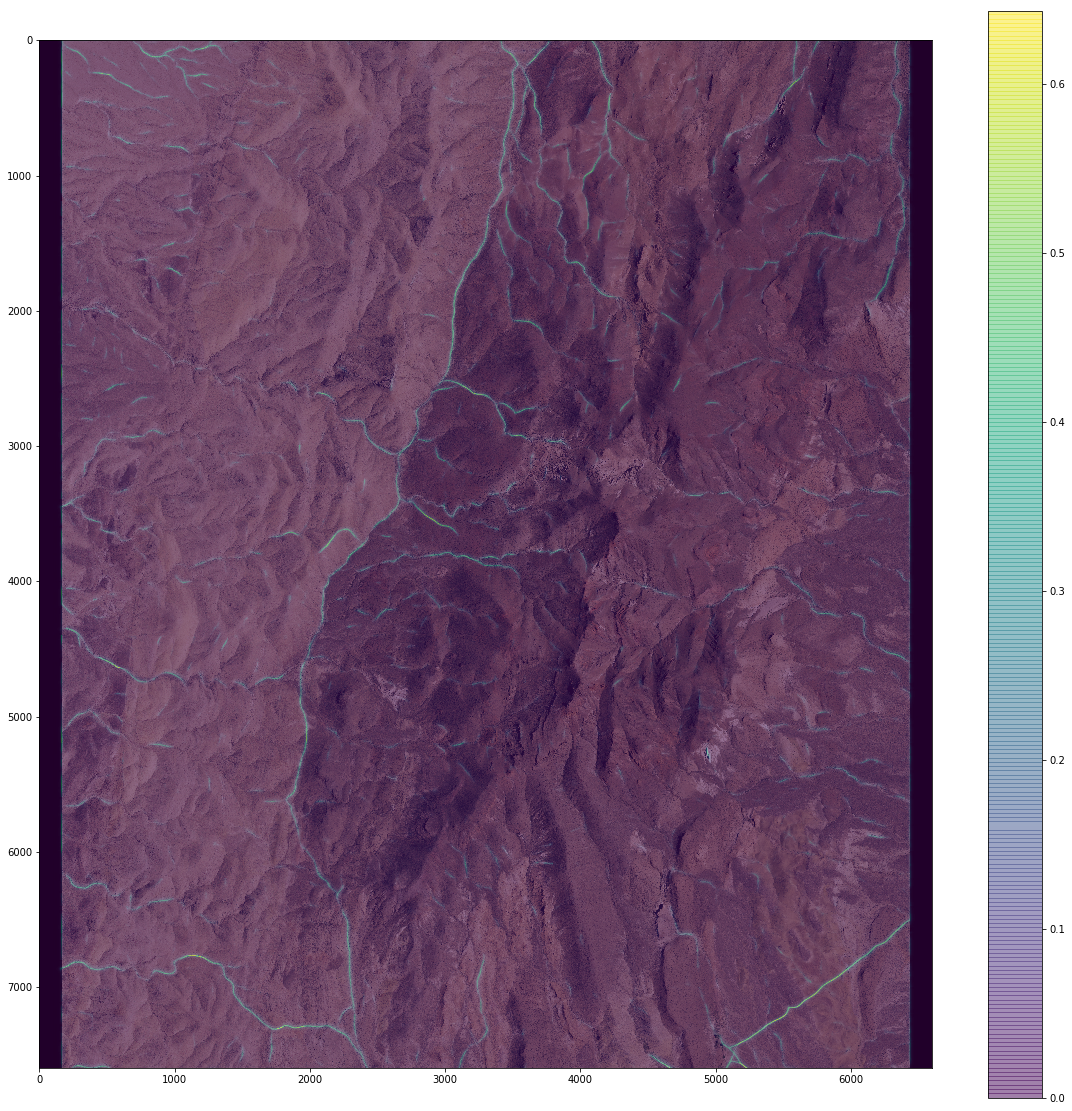

In [14]:
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(tif_img)
cax = ax.imshow(mos_tr, alpha=0.5)
cbar = f.colorbar(cax)
#f.savefig('predict_%s'%(tif_file[0]))

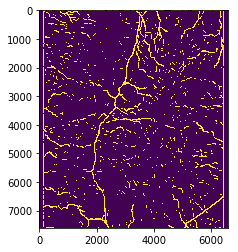

In [43]:
alpha_mask = np.zeros(np.shape(mos_tr))
thr=0.02
alpha_mask[mos_tr>thr] = 1
plt.imshow(alpha_mask)

In [57]:
tiffs = glob('*.tif')
print(tiffs)



['m_3711401_ne_11_1_20150725.tif']


'created /contents/bin/out/m_3711401_ne_11_1_20150725.tif'

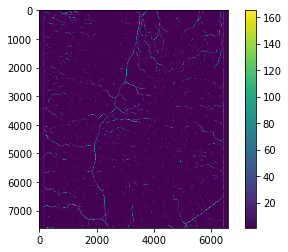

In [60]:
plt.imshow(alpha_mask);
plt.colorbar()



In [38]:
wd = '/contents/images/predict/b'
imgs = glob('%s/*.png'%(wd))
img_nums = list(set([i[-28:-21] for i in imgs]))
dates = list(set([i[-12:-4] for i in imgs]))
qq = list(set([i[-20:-18] for i in imgs]))
rows = list(set([i[-43:-39] for i in imgs]))
cols = list(set([i[-35:-31] for i in imgs]))

#gather by the specific i, d, and q
mosaic_names = []
crop = 1
for d in dates:
    for im in img_nums:
        for q in qq:
            data_dir = '%s/%s/%s/%s'%(wd, d, im, q)
            n=len(data_dir)
            subfiles = glob('%s/*.png'%data_dir)
            if (len(subfiles)==0): #sometimes we don't have that quadrat
                continue
            row_nums = list(set([int(i[-43:-39]) for i in subfiles]))
            col_nums = list(set([int(i[-35:-31]) for i in subfiles]))
            R = max(row_nums) #number of rows
            C = max(col_nums) #number of cols
            out_filename = '/contents/images/mosaics/v3/m_%s_%s_11_1_%s.png'%(im, q, d)
            #now window movement
            
            # 2 nested for loops
            bigcat = []
            for r in range(R+1):
                # get a list of names for that particular row
                z = [f for f in subfiles if 'row%04d'%r in f]
                row_list = []
                for c in range(C+1):
                    img = np.array(Image.open([ig for ig in z if 'col%04d'%(c) in ig][0]))
                    row_list.append(img) #crop the image
                bigcat.append(np.concatenate(row_list, axis=1))
            out = Image.fromarray(np.concatenate(bigcat, axis=0))
            out.save(out_filename)
            mosaic_names.append(out_filename)

In [95]:
mosaics = sorted(glob('/contents/images/mosaics/v3/*.png'))
tiffs = sorted(glob('/contents/images/predict/original/*.tif'))
mosaics[0][:-3]
# creates tif from the img
gt = []
proj = []
pr = []
imgs = []
shape_diff = []
for i in range(len(mosaics)):
    pr = np.array(Image.open(mosaics[i]))
    
    im = gdal.Open(tiffs[i])
    gt = im.GetGeoTransform()
    proj = im.GetProjection()
    xsize = im.RasterXSize
    ysize = im.RasterYSize
    shape_diff = np.array(pr_m.shape) - np.array([ysize, xsize])
    
    outfilename = mosaics[i][:-4] + '.tif'
    driver = gdal.GetDriverByName('GTiff')
    out = driver.Create(outfilename, xsize, ysize, 1, gdal.GDT_Byte)
    out.SetGeoTransform(gt)
    out.SetProjection(proj)
    out.GetRasterBand(1).WriteArray(pr[:-shape_diff[0],:-shape_diff[1]])

    